In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
#path = "/home/j.derks/mTRAQ_WC_THP1_mac_library_04202023.tsv"
path = '/work/slavov/JD/lib_prediction/LF_HYE_lib.tsv'
df = pd.read_csv(path, delimiter='\t')
original_df = pd.DataFrame(df)
distinct_df = original_df.drop_duplicates(subset='transition_group_id') #we don't need fragments for iRT prediction


distinct_df

,FileName,PrecursorMz,ProductMz,Tr_recalibrated,IonMobility,transition_name,LibraryIntensity,transition_group_id,decoy,PeptideSequence,...,PrecursorCharge,PeptideGroupLabel,UniprotID,NTerm,CTerm,FragmentType,FragmentCharge,FragmentSeriesNumber,FragmentLossType,ExcludeFromAssay
0,L:\RawData\E480\2024-08-14_LF-DIA_HYE_A_500ng.raw,715.41083,427.23050,-46.399208,0,AAAAAAAAK1_98_1_0_6,1.000000,AAAAAAAAK1,0,AAAAAAAAK,...,1,AAAAAAAAK,P43572,0,0,b,1,6,noloss,False
12,L:\RawData\E480\2024-08-14_LF-DIA_HYE_A_500ng.raw,956.55347,285.15628,-10.343023,0,AAAAAAALQAK1_98_1_0_4,0.307109,AAAAAAALQAK1,0,AAAAAAALQAK,...,1,AAAAAAALQAK,P36578,0,0,b,1,4,noloss,False
21,L:\RawData\E480\2024-08-14_LF-DIA_HYE_B_500ng.raw,478.78064,427.23050,-10.506976,0,AAAAAAALQAK2_98_1_0_6,0.096529,AAAAAAALQAK2,0,AAAAAAALQAK,...,2,AAAAAAALQAK,P36578,0,0,b,1,6,noloss,False
27,L:\RawData\E480\2024-08-14_LF-DIA_HYE_A_500ng.raw,514.31738,743.47852,35.015083,0,AAAAAATVLLR2_121_1_0_4,1.000000,AAAAAATVLLR2,0,AAAAAATVLLR,...,2,AAAAAATVLLR,O60779;O60779-2,0,0,y,1,7,noloss,True
39,L:\RawData\E480\2024-08-14_LF-DIA_HYE_A_500ng.raw,943.49664,473.28415,-17.558807,0,AAAAADLANR1_121_1_0_6,1.000000,AAAAADLANR1,0,AAAAADLANR,...,1,AAAAADLANR,O76031,0,0,y,1,4,noloss,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2080614,L:\RawData\E480\2024-08-14_LF-DIA_HYE_B_500ng.raw,1137.56260,535.28857,32.773846,0,YYYIPQYK1_121_1_0_4,1.000000,YYYIPQYK1,0,YYYIPQYK,...,1,YYYIPQYK,Q8N183,0,0,y,1,4,noloss,False
2080625,L:\RawData\E480\2024-08-14_LF-DIA_HYE_B_500ng.raw,569.28522,421.20926,32.730885,0,YYYIPQYK2_121_1_2_5,0.035727,YYYIPQYK2,0,YYYIPQYK,...,2,YYYIPQYK,Q8N183,0,0,y,1,3,NH3,False
2080631,L:\RawData\E480\2024-08-14_LF-DIA_HYE_A_500ng.raw,379.85941,535.28857,32.685314,0,YYYIPQYK3_121_1_0_4,1.000000,YYYIPQYK3,0,YYYIPQYK,...,3,YYYIPQYK,Q8N183,0,0,y,1,4,noloss,False
2080643,L:\RawData\E480\2024-08-14_LF-DIA_HYE_B_500ng.raw,843.39111,1097.51610,66.677704,0,YYYVPADFVEYEK2_121_1_0_4,1.000000,YYYVPADFVEYEK2,0,YYYVPADFVEYEK,...,2,YYYVPADFVEYEK,Q93100;Q93100-2;Q93100-3;Q93100-4,0,0,y,1,9,noloss,False


In [3]:

peptide_sequence = "ACDEFGHIKLMNPQRSTVWY"   
max_sequence_length = 30    
num_amino_acids = 20      #possible amino acids

amino_acid_to_index = {aa: i for i, aa in enumerate(peptide_sequence)}

def one_hot_encode_sequence(sequence):
    one_hot_sequence = np.zeros((max_sequence_length, num_amino_acids), dtype=np.float32)
    for i, aa in enumerate(sequence[:max_sequence_length]):
        aa_index = amino_acid_to_index.get(aa.upper(), None)
        if aa_index is not None:
            one_hot_sequence[i, aa_index] = 1.0
    return one_hot_sequence

#compute the average RT for each peptide sequence (average of the different charge states)
grouped_df = distinct_df.groupby('PeptideSequence', as_index=False).agg({
    'Tr_recalibrated': 'mean'
})

#onehot encode the peptide sequence
X_peptide = [one_hot_encode_sequence(seq) for seq in grouped_df['PeptideSequence']]

X = np.array(X_peptide)
Y = grouped_df['Tr_recalibrated'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=123)

print(f"Training data size: {X_train.shape}, Test data size: {X_test.shape}")

Training data size: (91657, 30, 20), Test data size: (10185, 30, 20)


Training model 1/5
Epoch 1/150
2578/2578 [==============================] - 40s 15ms/step - loss: 5.0143 - val_loss: 3.2643
Epoch 2/150
2578/2578 [==============================] - 37s 15ms/step - loss: 3.1313 - val_loss: 2.6521
Epoch 3/150
2578/2578 [==============================] - 37s 14ms/step - loss: 2.6750 - val_loss: 2.5390
Epoch 4/150
2578/2578 [==============================] - 37s 14ms/step - loss: 2.4465 - val_loss: 2.8149
Epoch 5/150
2578/2578 [==============================] - 38s 15ms/step - loss: 2.2796 - val_loss: 1.9875
Epoch 6/150
2578/2578 [==============================] - 37s 14ms/step - loss: 2.1314 - val_loss: 1.9313
Epoch 7/150
2578/2578 [==============================] - 38s 15ms/step - loss: 2.0414 - val_loss: 2.0083
Epoch 8/150
2578/2578 [==============================] - 37s 15ms/step - loss: 1.9614 - val_loss: 1.7102
Epoch 9/150
2578/2578 [==============================] - 37s 14ms/step - loss: 1.9216 - val_loss: 2.1079
Epoch 10/150
2578/2578 [============

INFO:tensorflow:Assets written to: iRT_CNN_model_LF_09182024_0/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_LF_09182024_1/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_LF_09182024_1/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_LF_09182024_2/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_LF_09182024_2/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_LF_09182024_3/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_LF_09182024_3/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_LF_09182024_4/assets


INFO:tensorflow:Assets written to: iRT_CNN_model_LF_09182024_4/assets


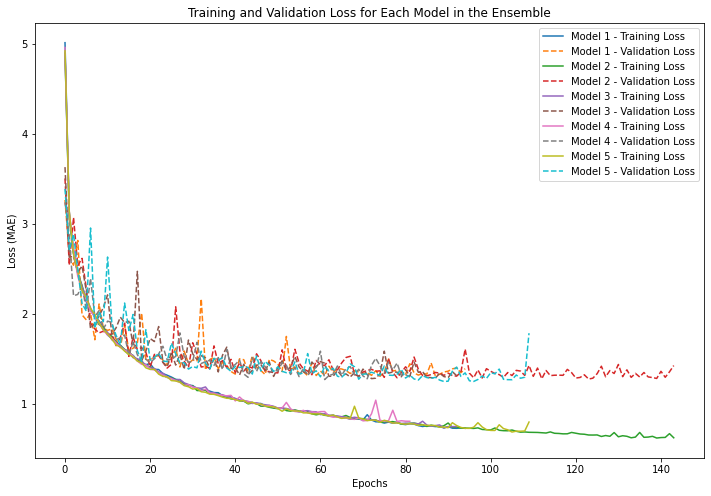

In [4]:
import tensorflow as tf
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

seed_value = 123
tf.random.set_seed(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

def build_model():
    model = Sequential()
    
    model.add(Conv1D(filters=32, kernel_size=4, activation='swish', padding='same'))
    model.add(MaxPooling1D(pool_size=1))

    model.add(Conv1D(filters=64, kernel_size=4, activation='swish', padding='same'))
    model.add(MaxPooling1D(pool_size=1))

    model.add(Conv1D(filters=128, kernel_size=4, activation='swish', padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=256, kernel_size=4, activation='swish', padding='same'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())

    # feed into dense layers
    model.add(Dense(1000, activation='swish'))
    model.add(Dense(256, activation='swish'))
    model.add(Dense(128, activation='swish'))
    model.add(Dense(64, activation='swish'))
    model.add(Dense(32, activation='swish'))

    model.add(Dense(1, activation='linear')) #this is the retention time (RT) output

    adam_optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=adam_optimizer, loss='mae')
    
    return model

# create an ensemble of 5 models.. this slightly helps and is probably worth the extra bit of time.
ensemble_size = 5
ensemble_models = []
history_list = []

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

for i in range(ensemble_size):
    print(f"Training model {i+1}/{ensemble_size}")
    model = build_model()
    history = model.fit(X_train, Y_train, epochs=150, batch_size=32, validation_split=0.1, callbacks=[early_stopping])
    ensemble_models.append(model)
    history_list.append(history.history)

test_losses = []
for i, model in enumerate(ensemble_models):
    print(f"Evaluating model {i+1}/{ensemble_size}")
    test_loss = model.evaluate(X_test, Y_test)
    test_losses.append(test_loss)
    print(f"Test loss for model {i+1}: {test_loss}")

predictions = np.zeros_like(Y_test)
for model in ensemble_models:
    predictions += model.predict(X_test).flatten()

predictions /= ensemble_size

ensemble_loss = np.mean(np.abs(predictions - Y_test))  #MAE for the ensemble
print(f"Ensemble test loss (MAE): {ensemble_loss}")

for i, model in enumerate(ensemble_models):
    model.save(f'iRT_CNN_model_LF_09182024_{i}')

plt.figure(figsize=(12, 8))
for i, history in enumerate(history_list):
    plt.plot(history['loss'], label=f'Model {i+1} - Training Loss')
    plt.plot(history['val_loss'], label=f'Model {i+1} - Validation Loss', linestyle='--')

plt.title('Training and Validation Loss for Each Model in the Ensemble')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.show()


In [4]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import r2_score

# Define model names
model_names = [f"iRT_CNN_model_LF_09182024_{i}" for i in range(5)]

# Load saved models
ensemble_models = [tf.keras.models.load_model(name) for name in model_names]

# Ensure test data is in NumPy format
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Calculate R-squared for each model
r2_scores = {}
for i, model in enumerate(ensemble_models):
    model_name = model_names[i]
    predictions = model.predict(X_test).flatten()  # Ensure 1D array
    r2_scores[model_name] = r2_score(Y_test, predictions)
    print(f'R-squared ({model_name}): {r2_scores[model_name]:.4f}')

# Calculate ensemble mean prediction
predictions = np.array([model.predict(X_test).flatten() for model in ensemble_models])
mean_prediction = np.mean(predictions, axis=0)

# Calculate R-squared for ensemble
r2_ensemble = r2_score(Y_test, mean_prediction)
print(f"\nR-squared (Ensemble): {r2_ensemble:.4f}")



319/319 [==============================] - 1s 4ms/step
R-squared (iRT_CNN_model_LF_09182024_0): 0.9964
319/319 [==============================] - 1s 4ms/step
R-squared (iRT_CNN_model_LF_09182024_1): 0.9965
319/319 [==============================] - 1s 4ms/step
R-squared (iRT_CNN_model_LF_09182024_2): 0.9966
319/319 [==============================] - 1s 4ms/step
R-squared (iRT_CNN_model_LF_09182024_3): 0.9964
319/319 [==============================] - 1s 4ms/step
R-squared (iRT_CNN_model_LF_09182024_4): 0.9967
319/319 [==============================] - 1s 4ms/step

R-squared (Ensemble): 0.9976


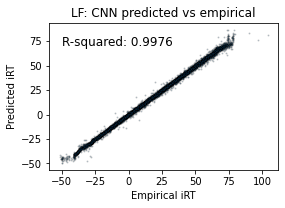

In [7]:


plt.figure(figsize=(4.1, 2.7))
plt.scatter(Y_test, mean_prediction, alpha=0.2, marker='o', edgecolor='k',s=1)
plt.xlabel('Empirical iRT')
plt.ylabel('Predicted iRT')
plt.title('LF: CNN predicted vs empirical')
plt.text(-50, 70, f"R-squared: {r2_ensemble:.4f}", fontsize = 12)

plt.savefig('pred_vs_emp_plot_CNN_LF.pdf',dpi=400)

plt.show()